<h2>FOR SOME tensorflow hub was getting installed on the existing virtual environment so I had to make
a new virtual environment to make it work</h2>

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import PIL
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow_hub as hub
import pathlib

In [2]:
# getting the trained model from tensorflow hub
image_shape = (192, 192)
model_path = 'https://tfhub.dev/google/imagenet/mobilenet_v2_035_192/classification/5'

classifier = keras.Sequential([
    hub.KerasLayer(model_path, input_shape=image_shape + (3, ))
])

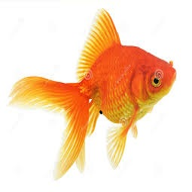

In [4]:
gold_fish = PIL.Image.open('./files/gold_fish.jpg').resize(image_shape)
gold_fish

In [5]:
gold_fish = np.array(gold_fish, dtype='uint8') / 255
gold_fish.shape

(192, 192, 3)

In [7]:
gold_fish[np.newaxis, ...].shape

(1, 192, 192, 3)

In [8]:
classifier.predict(gold_fish[np.newaxis, ...])

1/1 [==============================] - 1s 1s/step


array([[ 0.6469816,  2.1538918, 11.67488  , ..., -2.1718965,  1.9989071,
        -1.2915293]], dtype=float32)

In [9]:
y_pred_class = classifier.predict(gold_fish[np.newaxis, ...])

1/1 [==============================] - 0s 42ms/step


In [10]:
print(np.argmax(y_pred_class))

2


In [11]:
with open('./files/labels.txt', 'r') as txt_file:
    classes = txt_file.read().splitlines()

In [13]:
classes[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [12]:
print(classes[np.argmax(y_pred_class)])

goldfish


<h2>Lets try to make predictions using our previous notebooks images</h2>

In [14]:
path = 'C:/Users/User/Desktop/locales/deep_learning/datasets/flower_photos'
data_path = pathlib.Path(path)
data_path

WindowsPath('C:/Users/User/Desktop/locales/deep_learning/datasets/flower_photos')

In [15]:
flower_images_paths = {
    
    'roses': list(data_path.glob('*roses/*.jpg')),
    'sunflowers': list(data_path.glob('*sunflowers/*.jpg')),
    'tulips': list(data_path.glob('*tulips/*.jpg')),
    'daisy': list(data_path.glob('*daisy/*.jpg')),
    'dandelion': list(data_path.glob('*dandelion/*.jpg')),
}

flower_labels = {
    'roses': 0,
    'dandelion': 1,
    'daisy': 2,
    'sunflowers':3,
    'tulips': 4
}

In [16]:
len(flower_images_paths['roses'])

641

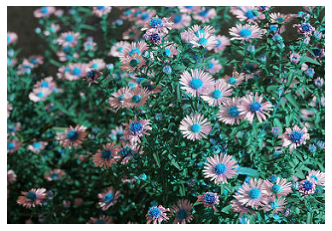

In [17]:
img = cv.imread(str(flower_images_paths['daisy'][15]))
plt.axis('off')
plt.imshow(img)
plt.show()

In [18]:
# a function which would resize the image
def get_resize_img(img):
    dimension = img.shape
    initial_area = dimension[0] * dimension[1]
    resize_shape = (192, 192)
    resized_area = 192 * 192
    if initial_area > resized_area:
        return cv.resize(img, resize_shape, interpolation=cv.INTER_AREA)
    else:
        return cv.resize(img, resize_shape, interpolation=cv.INTER_CUBIC)

In [19]:
# now we will go through all the flower_paths and read a image using opencv then store it in a x and store the corosponding label in y
x = []
y = []

for flower_name, flower_paths in flower_images_paths.items():
    for image_path in flower_paths:
        img = cv.imread(str(image_path))
        resized_img = get_resize_img(img)
        x.append(resized_img)
        label = flower_labels.get(flower_name)
        y.append(label)

In [20]:
# lets convert the x and y to numpy array for convinience

numpy_x = np.array(x, dtype='uint8')
numpy_y = np.array(y)
numpy_x.shape

(3670, 192, 192, 3)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(numpy_x, numpy_y, test_size=0.2, random_state=0)

In [22]:
x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

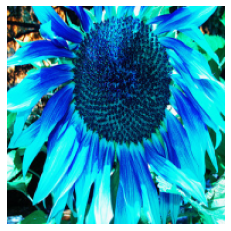

In [23]:
plt.axis('off')
plt.imshow(x_train[0])
plt.show()

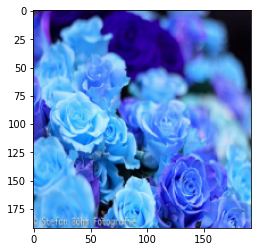

In [24]:
plt.imshow(x_train[2])

In [28]:
images = np.array(x_train_scaled[:5])
images.shape

(5, 192, 192, 3)

In [29]:
result = (classifier.predict(images))
result = [np.argmax(y_t) for y_t in result]

1/1 [==============================] - 0s 62ms/step


In [30]:
classes[result[0]], classes[result[1]], classes[result[2]], classes[result[3]], classes[result[4]]
# only one classification was correct which was daisy

('daisy', 'pinwheel', 'head cabbage', 'daisy', 'medicine chest')

<h2>We can not use the trained model of 1001 classification to predict our flower_dataset. We need
to just import the model before it is trained and given the last layers meaning the freeze part </h2>

In [33]:
freeze_path = 'https://tfhub.dev/google/imagenet/mobilenet_v2_035_192/feature_vector/5'

pretrained_model_without_top_layer = hub.KerasLayer(freeze_path, input_shape=(192, 192, 3), 
                                                    trainable=False) # False to not get trained model

In [35]:
num_of_flowers = 5

model = keras.Sequential([
    pretrained_model_without_top_layers,
    keras.layers.Dense(num_of_flowers, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              410208    
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 416,613
Trainable params: 6,405
Non-trainable params: 410,208
_________________________________________________________________


In [40]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.fit(x_train_scaled, y_train, epochs=5)

Epoch 1/5
92/92 [==============================] - 24s 210ms/step - loss: 0.2593 - accuracy: 0.9217
Epoch 2/5
92/92 [==============================] - 19s 204ms/step - loss: 0.2234 - accuracy: 0.9343
Epoch 3/5
92/92 [==============================] - 18s 196ms/step - loss: 0.1995 - accuracy: 0.9428
Epoch 4/5
92/92 [==============================] - 21s 224ms/step - loss: 0.1779 - accuracy: 0.9506
Epoch 5/5
92/92 [==============================] - 19s 209ms/step - loss: 0.1628 - accuracy: 0.9581


In [41]:
model.evaluate(x_test_scaled, y_test)

23/23 [==============================] - 6s 219ms/step - loss: 0.3945 - accuracy: 0.8529


[0.394523561000824, 0.8528610467910767]

<h1>There was a big improvement in accuracy from out prevous notebook name data augmentaion</h1>

<h2>It is better to get pretrained models hyper parameters and use them to train our model</h2>